# Assignment | 05-week3 -Part_1-Neural Machine Translation

该系列仅在原课程基础上课后作业部分添加个人学习笔记，如有错误，还请批评指教。- ZJ
    
>[Coursera 课程](https://www.coursera.org/specializations/deep-learning) |[deeplearning.ai](https://www.deeplearning.ai/) |[网易云课堂](https://mooc.study.163.com/smartSpec/detail/1001319001.htm)

 [CSDN]()：
   

---

Welcome to your first programming assignment for this week! 

You will build a Neural Machine Translation (NMT) model to translate human readable dates ("25th of June, 2009") into machine readable dates ("2009-06-25"). You will do this using an attention model, one of the most sophisticated sequence to sequence models. 

您将建立一个神经机器翻译（NMT）模型，将人类可读日期（“2009年6月25日”）转换为机器可读日期（“2009-06-25”）。您将使用注意模型来完成此操作，这是模型序列中最复杂的序列之一。

This notebook was produced together with NVIDIA's Deep Learning Institute. 

Let's load all the packages you will need for this assignment.

In [1]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline



d:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1 - Translating human readable dates into machine readable dates

The model you will build here could be used to translate from one language to another, such as translating from English to Hindi. However, language translation requires massive datasets and usually takes days of training on GPUs. To give you a place to experiment with these models even without using massive datasets, we will instead use a simpler "date translation" task. 

您将在此创建的模型可用于从一种语言翻译为另一种语言，如从英语翻译为印地语。 但是，语言翻译需要大量的数据集，并且通常需要几天的GPU训练。 为了让您有机会尝试这些模型，即使不使用海量数据集，我们也会使用更简单的“日期转换”任务。

The network will input a date written in a variety of possible formats (*e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987"*) and translate them into standardized, machine readable dates (*e.g. "1958-08-29", "1968-03-30", "1987-06-24"*). We will have the network learn to output dates in the common machine-readable format YYYY-MM-DD. 

tqdm（读音：taqadum, تقدّم）在阿拉伯语中的意思是进展。tqdm可以在长循环中添加一个进度提示信息，用户只需要封装任意的迭代器 tqdm (iterator)，是一个快速、扩展性强的进度条工具库

<!-- 
Take a look at [nmt_utils.py](./nmt_utils.py) to see all the formatting. Count and figure out how the formats work, you will need this knowledge later. !--> 

In [ ]:
'''
nmt_utils.py

要把这里面代码 都看懂，写注释 学一遍

'''


import numpy as np
from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt

fake = Faker()
fake.seed(12345)
random.seed(12345)

# Define format of the data we would like to generate
FORMATS = ['short',
           'medium',
           'long',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'full',
           'd MMM YYY', 
           'd MMMM YYY',
           'dd MMM YYY',
           'd MMM, YYY',
           'd MMMM, YYY',
           'dd, MMM YYY',
           'd MM YY',
           'd MMMM YYY',
           'MMMM d YYY',
           'MMMM d, YYY',
           'dd.MM.YY']

# change this if you want it to work with another language
LOCALES = ['en_US']

def load_date():
    """
        Loads some fake dates 
        :returns: tuple containing human readable string, machine readable string, and date object
    """
    dt = fake.date_object()

    try:
        human_readable = format_date(dt, format=random.choice(FORMATS),  locale='en_US') # locale=random.choice(LOCALES))
        human_readable = human_readable.lower()
        human_readable = human_readable.replace(',','')
        machine_readable = dt.isoformat()
        
    except AttributeError as e:
        return None, None, None

    return human_readable, machine_readable, dt

def load_dataset(m):
    """
        Loads a dataset with m examples and vocabularies
        :m: the number of examples to generate
    """
    
    human_vocab = set()
    machine_vocab = set()
    dataset = []
    Tx = 30
    

    for i in tqdm(range(m)):
        h, m, _ = load_date()
        if h is not None:
            dataset.append((h, m))
            human_vocab.update(tuple(h))
            machine_vocab.update(tuple(m))
    
    human = dict(zip(sorted(human_vocab) + ['<unk>', '<pad>'], 
                     list(range(len(human_vocab) + 2))))
    inv_machine = dict(enumerate(sorted(machine_vocab)))
    machine = {v:k for k,v in inv_machine.items()}
 
    return dataset, human, machine, inv_machine

def preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty):
    
    X, Y = zip(*dataset)
    
    X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
    Y = [string_to_int(t, Ty, machine_vocab) for t in Y]
    
    Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), X)))
    Yoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), Y)))

    return X, np.array(Y), Xoh, Yoh

def string_to_int(string, length, vocab):
    """
    Converts all strings in the vocabulary into a list of integers representing the positions of the
    input string's characters in the "vocab"
    
    Arguments:
    string -- input string, e.g. 'Wed 10 Jul 2007'
    length -- the number of time steps you'd like, determines if the output will be padded or cut
    vocab -- vocabulary, dictionary used to index every character of your "string"
    
    Returns:
    rep -- list of integers (or '<unk>') (size = length) representing the position of the string's character in the vocabulary
    """
    
    #make lower to standardize
    string = string.lower()
    string = string.replace(',','')
    
    if len(string) > length:
        string = string[:length]
        
    rep = list(map(lambda x: vocab.get(x, '<unk>'), string))
    
    if len(string) < length:
        rep += [vocab['<pad>']] * (length - len(string))
    
    #print (rep)
    return rep


def int_to_string(ints, inv_vocab):
    """
    Output a machine readable list of characters based on a list of indexes in the machine's vocabulary
    
    Arguments:
    ints -- list of integers representing indexes in the machine's vocabulary
    inv_vocab -- dictionary mapping machine readable indexes to machine readable characters 
    
    Returns:
    l -- list of characters corresponding to the indexes of ints thanks to the inv_vocab mapping
    """
    
    l = [inv_vocab[i] for i in ints]
    return l


EXAMPLES = ['3 May 1979', '5 Apr 09', '20th February 2016', 'Wed 10 Jul 2007']

def run_example(model, input_vocabulary, inv_output_vocabulary, text):
    encoded = string_to_int(text, TIME_STEPS, input_vocabulary)
    prediction = model.predict(np.array([encoded]))
    prediction = np.argmax(prediction[0], axis=-1)
    return int_to_string(prediction, inv_output_vocabulary)

def run_examples(model, input_vocabulary, inv_output_vocabulary, examples=EXAMPLES):
    predicted = []
    for example in examples:
        predicted.append(''.join(run_example(model, input_vocabulary, inv_output_vocabulary, example)))
        print('input:', example)
        print('output:', predicted[-1])
    return predicted


def softmax(x, axis=1):
    """Softmax activation function.
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')
        

def plot_attention_map(model, input_vocabulary, inv_output_vocabulary, text, n_s = 128, num = 6, Tx = 30, Ty = 10):
    """
    Plot the attention map.
  
    """
    attention_map = np.zeros((10, 30))
    Ty, Tx = attention_map.shape
    
    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    layer = model.layers[num]

    encoded = np.array(string_to_int(text, Tx, input_vocabulary)).reshape((1, 30))
    encoded = np.array(list(map(lambda x: to_categorical(x, num_classes=len(input_vocabulary)), encoded)))

    f = K.function(model.inputs, [layer.get_output_at(t) for t in range(Ty)])
    r = f([encoded, s0, c0])
    
    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0,t_prime,0]

    # Normalize attention map
#     row_max = attention_map.max(axis=1)
#     attention_map = attention_map / row_max[:, None]

    prediction = model.predict([encoded, s0, c0])
    
    predicted_text = []
    for i in range(len(prediction)):
        predicted_text.append(int(np.argmax(prediction[i], axis=1)))
        
    predicted_text = list(predicted_text)
    predicted_text = int_to_string(predicted_text, inv_output_vocabulary)
    text_ = list(text)
    
    # get the lengths of the string
    input_length = len(text)
    output_length = Ty
    
    # Plot the attention_map
    plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # add labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

    #f.show()
    
    return attention_map

### 1.1 - Dataset

We will train the model on a dataset of 10000 human readable dates and their equivalent, standardized, machine readable dates. Let's run the following cells to load the dataset and print some examples. 

In [2]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|█████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 14157.20it/s]


In [3]:
print(dataset[:10]) # 0 到 9 不包含 10 
print(dataset[0])
print(type(dataset))

[('9 may 1998', '1998-05-09'), ('10.09.70', '1970-09-10'), ('4/28/90', '1990-04-28'), ('thursday january 26 1995', '1995-01-26'), ('monday march 7 1983', '1983-03-07'), ('sunday may 22 1988', '1988-05-22'), ('tuesday july 8 2008', '2008-07-08'), ('08 sep 1999', '1999-09-08'), ('1 jan 1981', '1981-01-01'), ('monday may 22 1995', '1995-05-22')]
('9 may 1998', '1998-05-09')
<class 'list'>


You've loaded:
- `dataset`: a list of tuples of (human readable date, machine readable date) 元组的 list
- `human_vocab`: a python dictionary mapping all characters used in the human readable dates to an integer-valued index  一个Python字典将人类可读日期中使用的所有字符映射为整数值索引
- `machine_vocab`: a python dictionary mapping all characters used in machine readable dates to an integer-valued index. These indices are not necessarily consistent with `human_vocab`. 
- `inv_machine_vocab`: the inverse dictionary of `machine_vocab`, mapping from indices back to characters. 

Let's preprocess the data and map the raw text data into the index values. We will also use Tx=30 (which we assume is the maximum length of the human readable date; if we get a longer input, we would have to truncate it) and Ty=10 (since "YYYY-MM-DD" is 10 characters long). 

我们预处理数据并将原始文本数据映射到索引值。 我们还将使用Tx = 30（我们假设它是人类可读日期的最大长度;如果我们得到更长的输入，我们将不得不截断它）并且Ty = 10（因为“YYYY-MM-DD”是10 长字符）。

In [4]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


You now have:
- `X`: a processed version of the human readable dates in the training set, where each character is replaced by an index mapped to the character via `human_vocab`. Each date is further padded to $T_x$ values with a special character (< pad >). `X.shape = (m, Tx)` 
- `Y`: a processed version of the machine readable dates in the training set, where each character is replaced by the index it is mapped to in `machine_vocab`. You should have `Y.shape = (m, Ty)`. 
- `Xoh`: one-hot version of `X`, the "1" entry's index is mapped to the character thanks to `human_vocab`. `Xoh.shape = (m, Tx, len(human_vocab))`
- `Yoh`: one-hot version of `Y`, the "1" entry's index is mapped to the character thanks to `machine_vocab`. `Yoh.shape = (m, Tx, len(machine_vocab))`. Here, `len(machine_vocab) = 11` since there are 11 characters ('-' as well as 0-9). 


- `X`: 训练集中人类可读日期的处理版本，其中每个字符由通过 `human_vocab` 映射到字符的索引替换。 每个日期用特殊字符（<pad>）进一步填充到 $T_x$ 值。 `X.shape = (m, Tx)`
    
- `Y`: 训练集中机器可读日期的处理版本，其中每个字符都被其映射到`machine_vocab`中的索引替换。 你应该有`Y.shape =（m，Ty）`。 
- `Xoh`:一个 one-hot 向量版本的`X`，由于`human_vocab`，“1”条目的索引被映射到字符。 `Xoh.shape =（m，Tx，len（human_vocab））`
- `Yoh`: “Y”的one-hot 向量 版本，由于“machine_vocab”，“1”条目的索引被映射到字符。 `Yoh.shape =（m，Tx，len（machine_vocab））`。 这里`len（machine_vocab）= 11`因为有11个字符（' - '和0-9）。

Lets also look at some examples of preprocessed training examples. Feel free to play with `index` in the cell below to navigate the dataset and see how source/target dates are preprocessed. 

我们也看一些预处理训练例子的例子。 随意使用下面的单元格中的`index`来浏览数据集，并查看如何预处理源/目标日期。

In [6]:
index = 5
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: sunday may 22 1988
Target date: 1988-05-22

Source after preprocessing (indices): [29 31 25 16 13 34  0 24 13 34  0  5  5  0  4 12 11 11 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10  9  9  0  1  6  0  3  3]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


## 2 - Neural machine translation with attention

If you had to translate a book's paragraph from French to English, you would not read the whole paragraph, then close the book and translate. Even during the translation process, you would read/re-read and focus on the parts of the French paragraph corresponding to the parts of the English you are writing down. 

The attention mechanism tells a Neural Machine Translation model where it should pay attention to at any step. 


如果你必须把一个书的段落从法文翻译成英文，你不会阅读整段，然后合上书本并翻译。 即使在翻译过程中，您也会阅读/重读，并专注于与您正在写下的英语部分相对应的法语段落的部分。

注意力机制告诉神经机器翻译模型，在任何一个步骤中应该注意它。

### 2.1 - Attention mechanism

In this part, you will implement the attention mechanism presented in the lecture videos. Here is a figure to remind you how the model works. The diagram on the left shows the attention model. The diagram on the right shows what one "Attention" step does to calculate the attention variables $\alpha^{\langle t, t' \rangle}$, which are used to compute the context variable $context^{\langle t \rangle}$ for each timestep in the output ($t=1, \ldots, T_y$).（concatenate 串联）

在这一部分，您将实现视频中提出的注意力机制。 这是一个提醒你模型如何工作运行的图。 左侧的图表显示了注意力模型。 右图显示了“注意力”步骤计算注意力变量的方法$\alpha^{\langle t, t' \rangle}$, 用于计算上下文变量 $context^{\langle t \rangle}$ 用于输出中的每个时间步($t=1, \ldots, T_y$).

<table>
<td> 
<img src="images/attn_model.png" style="width:500;height:500px;"> <br>
</td> 
<td> 
<img src="images/attn_mechanism.png" style="width:500;height:500px;"> <br>
</td> 
</table>
<caption><center> **Figure 1**: Neural machine translation with attention</center></caption>



Here are some properties of the model that you may notice: 

- There are two separate LSTMs in this model (see diagram on the left). Because the one at the bottom of the picture is a Bi-directional LSTM and comes *before* the attention mechanism, we will call it *pre-attention* Bi-LSTM. The LSTM at the top of the diagram comes *after* the attention mechanism, so we will call it the *post-attention* LSTM. The pre-attention Bi-LSTM goes through $T_x$ time steps; the post-attention LSTM goes through $T_y$ time steps. 

（在这个模型中有两个单独的 LSTM（见左图）。 因为图片底部的一个是双向 LSTM，并且在关注机制之前，我们将其称为注意力前的 Bi-LSTM。 图表顶部的 LSTM出现在关注机制之后，因此我们将其称为注意力后的 LSTM。 预注意 Bi-LST 经过 $T_x$ 时间步长; 后注意力 LSTM 经历$T_y$ 的时间步骤。）

- The post-attention LSTM passes $s^{\langle t \rangle}, c^{\langle t \rangle}$ from one time step to the next. In the lecture videos, we were using only a basic RNN for the post-activation sequence model, so the state captured by the RNN output activations $s^{\langle t\rangle}$. But since we are using an LSTM here, the LSTM has both the output activation $s^{\langle t\rangle}$ and the hidden cell state $c^{\langle t\rangle}$. However, unlike previous text generation examples (such as Dinosaurus in week 1), in this model the post-activation LSTM at time $t$ does will not take the specific generated $y^{\langle t-1 \rangle}$ as input; it only takes $s^{\langle t\rangle}$ and $c^{\langle t\rangle}$ as input. We have designed the model this way, because (unlike language generation where adjacent characters are highly correlated) there isn't as strong a dependency between the previous character and the next character in a YYYY-MM-DD date. 

后注意力 LSTM 从一个时间步到下一个时间通过 $s^{\langle t \rangle}, c^{\langle t \rangle}$。 在讲座视频中，我们仅使用了基本的 RNN 作为激活后序列模型，因此 RNN 输出激活捕获的状态为  $s^{\langle t\rangle}$. 但是由于我们在这里使用 LSTM，因此 LSTM 同时具有输出激活$s^{\langle t\rangle}$ 和隐藏单元状态 $c^{\langle t\rangle}$. 然而，与以前的文本生成示例（如第1周的 Dinosaurus）不同，在此模型中，$t$ 后的激活后 LSTM 不会将具体产生的 $y^{\langle t-1 \rangle}$作为输入; 它只需要 $s^{\langle t\rangle}$ and $c^{\langle t\rangle}$ a为输入。 我们以这种方式设计了模型，因为（与邻近字符高度相关的语言生成不同），在 YYYY-MM-DD 日期中，前一个字符与下一个字符之间的依赖性不强。

- We use $a^{\langle t \rangle} = [\overrightarrow{a}^{\langle t \rangle}; \overleftarrow{a}^{\langle t \rangle}]$ to represent the concatenation of the activations of both the forward-direction and backward-directions of the pre-attention Bi-LSTM. 我们用  $a^{\langle t \rangle} = [\overrightarrow{a}^{\langle t \rangle}; \overleftarrow{a}^{\langle t \rangle}]$以表示预注意Bi-LSTM的前向和后向激活的连接。

- The diagram on the right uses a `RepeatVector` node to copy $s^{\langle t-1 \rangle}$'s value $T_x$ times, and then `Concatenation` to concatenate $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ to compute $e^{\langle t, t'}$, which is then passed through a softmax to compute $\alpha^{\langle t, t' \rangle}$. We'll explain how to use `RepeatVector` and `Concatenation` in Keras below. 

Lets implement this model. You will start by implementing two functions: `one_step_attention()` and `model()`.

**1) `one_step_attention()`**: At step $t$, given all the hidden states of the Bi-LSTM ($[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$) and the previous hidden state of the second LSTM ($s^{<t-1>}$), `one_step_attention()` will compute the attention weights ($[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$) and output the context vector (see Figure  1 (right) for details):
$$context^{<t>} = \sum_{t' = 0}^{T_x} \alpha^{<t,t'>}a^{<t'>}\tag{1}$$ 

Note that we are denoting the attention in this notebook $context^{\langle t \rangle}$. In the lecture videos, the context was denoted $c^{\langle t \rangle}$, but here we are calling it $context^{\langle t \rangle}$ to avoid confusion with the (post-attention) LSTM's internal memory cell variable, which is sometimes also denoted $c^{\langle t \rangle}$. 
  
**2) `model()`**: Implements the entire model. It first runs the input through a Bi-LSTM to get back $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$. Then, it calls `one_step_attention()` $T_y$ times (`for` loop). At each iteration of this loop, it gives the computed context vector $c^{<t>}$ to the second LSTM, and runs the output of the LSTM through a dense layer with softmax activation to generate a prediction $\hat{y}^{<t>}$. 

[CSDN: DenseNet 简介](https://blog.csdn.net/bryan__/article/details/77337109):https://blog.csdn.net/bryan__/article/details/77337109


**Exercise**: Implement `one_step_attention()`. The function `model()` will call the layers in `one_step_attention()` $T_y$ using a for-loop, and it is important that all $T_y$ copies have the same weights. I.e., it should not re-initiaiize the weights every time. In other words, all $T_y$ steps should have shared weights. Here's how you can implement layers with shareable weights in Keras (它不应该每次重新初始化权重。 换句话说，所有 $T_y$  步骤应该具有共享权重。 以下是如何在Keras中实现可共享权重的图层：):
1. Define the layer objects (as global variables for examples).
2. Call these objects when propagating the input.

We have defined the layers you need as global variables. Please run the following cells to create them. Please check the Keras documentation to make sure you understand what these layers are: [RepeatVector()](https://keras.io/layers/core/#repeatvector), [Concatenate()](https://keras.io/layers/merge/#concatenate), [Dense()](https://keras.io/layers/core/#dense), [Activation()](https://keras.io/layers/core/#activation), [Dot()](https://keras.io/layers/merge/#dot).

In [7]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

Now you can use these layers to implement `one_step_attention()`. In order to propagate a Keras tensor object X through one of these layers, use `layer(X)` (or `layer([X,Y])` if it requires multiple inputs.), e.g. `densor(X)` will propagate X through the `Dense(1)` layer defined above.

In [8]:
# GRADED FUNCTION: one_step_attention

def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
    
    ### START CODE HERE ###
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    concat = concatenator([a, s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas, a])
    ### END CODE HERE ###
    
    return context

You will be able to check the expected output of `one_step_attention()` after you've coded the `model()` function.

**Exercise**: Implement `model()` as explained in figure 2 and the text above. Again, we have defined global layers that will share weights to be used in `model()`.

In [9]:
n_a = 32
n_s = 64
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)

Now you can use these layers $T_y$ times in a `for` loop to generate the outputs, and their parameters will not be reinitialized. You will have to carry out the following steps: 

1. Propagate the input into a [Bidirectional](https://keras.io/layers/wrappers/#bidirectional) [LSTM](https://keras.io/layers/recurrent/#lstm)
2. Iterate for $t = 0, \dots, T_y-1$: 
    1. Call `one_step_attention()` on $[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$ and $s^{<t-1>}$ to get the context vector $context^{<t>}$.
    2. Give $context^{<t>}$ to the post-attention LSTM cell. Remember pass in the previous hidden-state $s^{\langle t-1\rangle}$ and cell-states $c^{\langle t-1\rangle}$ of this LSTM using `initial_state= [previous hidden state, previous cell state]`. Get back the new hidden state $s^{<t>}$ and the new cell state $c^{<t>}$.
    3. Apply a softmax layer to $s^{<t>}$, get the output. 
    4. Save the output by adding it to the list of outputs.

3. Create your Keras model instance, it should have three inputs ("inputs", $s^{<0>}$ and $c^{<0>}$) and output the list of "outputs".

In [12]:
# GRADED FUNCTION: model

def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    ### START CODE HERE ###
    
    # Step 1: Define your pre-attention Bi-LSTM. Remember to use return_sequences=True. (≈ 1 line)
    a = Bidirectional(LSTM(n_a, return_sequences=True), input_shape=(m, Tx, n_a*2))(X)
    print(a.shape)
    print(Ty)
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(context, initial_state = [s, c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model(inputs=[X,s0,c0],outputs=outputs)
    
    ### END CODE HERE ###
    
    return model

Run the following cell to create your model.

In [13]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

(?, ?, 64)
10


Let's get a summary of the model to check if it matches the expected output.

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 30, 64)       17920       input_2[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]                     
          

                                                                 attention_weights[4][0]          
                                                                 bidirectional_2[0][0]            
                                                                 attention_weights[5][0]          
                                                                 bidirectional_2[0][0]            
                                                                 attention_weights[6][0]          
                                                                 bidirectional_2[0][0]            
                                                                 attention_weights[7][0]          
                                                                 bidirectional_2[0][0]            
                                                                 attention_weights[8][0]          
                                                                 bidirectional_2[0][0]            
          

**Expected Output**:

Here is the summary you should see
<table>
    <tr>
        <td>
            **Total params:**
        </td>
        <td>
         185,484
        </td>
    </tr>
        <tr>
        <td>
            **Trainable params:**
        </td>
        <td>
         185,484
        </td>
    </tr>
            <tr>
        <td>
            **Non-trainable params:**
        </td>
        <td>
         0
        </td>
    </tr>
                    <tr>
        <td>
            **bidirectional_1's output shape **
        </td>
        <td>
         (None, 30, 128)  
        </td>
    </tr>
    <tr>
        <td>
            **repeat_vector_1's output shape **
        </td>
        <td>
         (None, 30, 128)  
        </td>
    </tr>
                <tr>
        <td>
            **concatenate_1's output shape **
        </td>
        <td>
         (None, 30, 256) 
        </td>
    </tr>
            <tr>
        <td>
            **attention_weights's output shape **
        </td>
        <td>
         (None, 30, 1)  
        </td>
    </tr>
        <tr>
        <td>
            **dot_1's output shape **
        </td>
        <td>
         (None, 1, 128) 
        </td>
    </tr>
           <tr>
        <td>
            **dense_2's output shape **
        </td>
        <td>
         (None, 11) 
        </td>
    </tr>
</table>


最后得出的相关参数，与预期的参数不同，要看下为啥。

As usual, after creating your model in Keras, you need to compile it and define what loss, optimizer and metrics your are want to use.像往常一样，在Keras中创建模型后，您需要编译它并定义要使用的损失，优化程序和指标。 Compile your model using `categorical_crossentropy` loss, a custom [Adam](https://keras.io/optimizers/#adam) [optimizer](https://keras.io/optimizers/#usage-of-optimizers) (`learning rate = 0.005`, $\beta_1 = 0.9$, $\beta_2 = 0.999$, `decay = 0.01`)  and `['accuracy']` metrics:

In [16]:
### START CODE HERE ### (≈2 lines)
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
### END CODE HERE ###

The last step is to define all your inputs and outputs to fit the model:
- You already have X of shape $(m = 10000, T_x = 30)$ containing the training examples.
- You need to create `s0` and `c0` to initialize your `post_activation_LSTM_cell` with 0s.
- Given the `model()` you coded, you need the "outputs" to be a list of 11 elements of shape (m, T_y). So that: `outputs[i][0], ..., outputs[i][Ty]` represent the true labels (characters) corresponding to the $i^{th}$ training example (`X[i]`). More generally, `outputs[i][j]` is the true label of the $j^{th}$ character in the $i^{th}$ training example.

In [17]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

Let's now fit the model and run it for one epoch.

In [18]:
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

Epoch 1/1


 1600/10000 [===>..........................] - ETA: 18:21 - loss: 23.9635 - dense_3_loss_1: 2.4029 - dense_3_loss_2: 2.3787 - dense_3_loss_3: 2.3947 - dense_3_loss_4: 2.3965 - dense_3_loss_5: 2.4078 - dense_3_loss_6: 2.3760 - dense_3_loss_7: 2.4009 - dense_3_loss_8: 2.4096 - dense_3_loss_9: 2.3987 - dense_3_loss_10: 2.3977 - dense_3_acc_1: 0.0000e+00 - dense_3_acc_2: 0.0900 - dense_3_acc_3: 0.1000 - dense_3_acc_4: 0.0800 - dense_3_acc_5: 0.0000e+00 - dense_3_acc_6: 0.0100 - dense_3_acc_7: 0.0500 - dense_3_acc_8: 0.0000e+00 - dense_3_acc_9: 0.0000e+00 - dense_3_acc_10: 0.130 - ETA: 9:10 - loss: 23.7224 - dense_3_loss_1: 2.3929 - dense_3_loss_2: 2.3608 - dense_3_loss_3: 2.3881 - dense_3_loss_4: 2.4066 - dense_3_loss_5: 2.3475 - dense_3_loss_6: 2.3221 - dense_3_loss_7: 2.4053 - dense_3_loss_8: 2.3386 - dense_3_loss_9: 2.3616 - dense_3_loss_10: 2.3989 - dense_3_acc_1: 0.0000e+00 - dense_3_acc_2: 0.1700 - dense_3_acc_3: 0.1400 - dense_3_acc_4: 0.0700 - dense_3_acc_5: 0.1350 - dense_3_acc_6:

 3200/10000 [========>.....................] - ETA: 1:02 - loss: 21.9262 - dense_3_loss_1: 2.2247 - dense_3_loss_2: 2.1354 - dense_3_loss_3: 2.3549 - dense_3_loss_4: 2.6645 - dense_3_loss_5: 1.6578 - dense_3_loss_6: 1.8005 - dense_3_loss_7: 2.6595 - dense_3_loss_8: 1.5577 - dense_3_loss_9: 2.0756 - dense_3_loss_10: 2.7956 - dense_3_acc_1: 0.1165 - dense_3_acc_2: 0.1712 - dense_3_acc_3: 0.0794 - dense_3_acc_4: 0.0371 - dense_3_acc_5: 0.6824 - dense_3_acc_6: 0.1306 - dense_3_acc_7: 0.0182 - dense_3_acc_8: 0.7753 - dense_3_acc_9: 0.0571 - dense_3_acc_10: 0.02 - ETA: 58s - loss: 21.8677 - dense_3_loss_1: 2.2190 - dense_3_loss_2: 2.1134 - dense_3_loss_3: 2.3466 - dense_3_loss_4: 2.6801 - dense_3_loss_5: 1.6398 - dense_3_loss_6: 1.7869 - dense_3_loss_7: 2.6662 - dense_3_loss_8: 1.5396 - dense_3_loss_9: 2.0746 - dense_3_loss_10: 2.8014 - dense_3_acc_1: 0.1128 - dense_3_acc_2: 0.1861 - dense_3_acc_3: 0.0861 - dense_3_acc_4: 0.0406 - dense_3_acc_5: 0.6578 - dense_3_acc_6: 0.1233 - dense_3_acc_7

 4800/10000 [=============>................] - ETA: 28s - loss: 21.0850 - dense_3_loss_1: 2.0901 - dense_3_loss_2: 1.7716 - dense_3_loss_3: 2.2461 - dense_3_loss_4: 2.8295 - dense_3_loss_5: 1.4463 - dense_3_loss_6: 1.7428 - dense_3_loss_7: 2.7047 - dense_3_loss_8: 1.4429 - dense_3_loss_9: 2.0196 - dense_3_loss_10: 2.7914 - dense_3_acc_1: 0.0655 - dense_3_acc_2: 0.3645 - dense_3_acc_3: 0.1588 - dense_3_acc_4: 0.0500 - dense_3_acc_5: 0.8133 - dense_3_acc_6: 0.0673 - dense_3_acc_7: 0.0094 - dense_3_acc_8: 0.8842 - dense_3_acc_9: 0.0427 - dense_3_acc_10: 0.020 - ETA: 27s - loss: 21.0281 - dense_3_loss_1: 2.0786 - dense_3_loss_2: 1.7538 - dense_3_loss_3: 2.2327 - dense_3_loss_4: 2.8345 - dense_3_loss_5: 1.4333 - dense_3_loss_6: 1.7398 - dense_3_loss_7: 2.7100 - dense_3_loss_8: 1.4382 - dense_3_loss_9: 2.0150 - dense_3_loss_10: 2.7921 - dense_3_acc_1: 0.0635 - dense_3_acc_2: 0.3729 - dense_3_acc_3: 0.1659 - dense_3_acc_4: 0.0512 - dense_3_acc_5: 0.8188 - dense_3_acc_6: 0.0653 - dense_3_acc_7

 6400/10000 [==================>...........] - ETA: 16s - loss: 20.1808 - dense_3_loss_1: 1.8486 - dense_3_loss_2: 1.5354 - dense_3_loss_3: 2.0828 - dense_3_loss_4: 2.8442 - dense_3_loss_5: 1.2790 - dense_3_loss_6: 1.7250 - dense_3_loss_7: 2.7405 - dense_3_loss_8: 1.4074 - dense_3_loss_9: 1.9381 - dense_3_loss_10: 2.7795 - dense_3_acc_1: 0.2251 - dense_3_acc_2: 0.4616 - dense_3_acc_3: 0.2216 - dense_3_acc_4: 0.0467 - dense_3_acc_5: 0.8743 - dense_3_acc_6: 0.0453 - dense_3_acc_7: 0.0076 - dense_3_acc_8: 0.8800 - dense_3_acc_9: 0.0941 - dense_3_acc_10: 0.057 - ETA: 15s - loss: 20.1248 - dense_3_loss_1: 1.8316 - dense_3_loss_2: 1.5213 - dense_3_loss_3: 2.0756 - dense_3_loss_4: 2.8453 - dense_3_loss_5: 1.2697 - dense_3_loss_6: 1.7202 - dense_3_loss_7: 2.7428 - dense_3_loss_8: 1.4061 - dense_3_loss_9: 1.9343 - dense_3_loss_10: 2.7779 - dense_3_acc_1: 0.2334 - dense_3_acc_2: 0.4692 - dense_3_acc_3: 0.2246 - dense_3_acc_4: 0.0464 - dense_3_acc_5: 0.8768 - dense_3_acc_6: 0.0444 - dense_3_acc_7

 8000/10000 [=======================>......] - ETA: 9s - loss: 18.9504 - dense_3_loss_1: 1.5888 - dense_3_loss_2: 1.3321 - dense_3_loss_3: 1.9724 - dense_3_loss_4: 2.8125 - dense_3_loss_5: 1.0965 - dense_3_loss_6: 1.5641 - dense_3_loss_7: 2.7574 - dense_3_loss_8: 1.2384 - dense_3_loss_9: 1.8572 - dense_3_loss_10: 2.7310 - dense_3_acc_1: 0.3272 - dense_3_acc_2: 0.5502 - dense_3_acc_3: 0.2551 - dense_3_acc_4: 0.0434 - dense_3_acc_5: 0.9049 - dense_3_acc_6: 0.1683 - dense_3_acc_7: 0.0166 - dense_3_acc_8: 0.9038 - dense_3_acc_9: 0.1568 - dense_3_acc_10: 0.07 - ETA: 8s - loss: 18.8554 - dense_3_loss_1: 1.5760 - dense_3_loss_2: 1.3225 - dense_3_loss_3: 1.9655 - dense_3_loss_4: 2.8070 - dense_3_loss_5: 1.0824 - dense_3_loss_6: 1.5524 - dense_3_loss_7: 2.7529 - dense_3_loss_8: 1.2220 - dense_3_loss_9: 1.8499 - dense_3_loss_10: 2.7246 - dense_3_acc_1: 0.3300 - dense_3_acc_2: 0.5539 - dense_3_acc_3: 0.2571 - dense_3_acc_4: 0.0453 - dense_3_acc_5: 0.9064 - dense_3_acc_6: 0.1768 - dense_3_acc_7: 0

 9600/10000 [===========================>..] - ETA: 4s - loss: 17.5139 - dense_3_loss_1: 1.3906 - dense_3_loss_2: 1.1668 - dense_3_loss_3: 1.8582 - dense_3_loss_4: 2.7362 - dense_3_loss_5: 0.8931 - dense_3_loss_6: 1.3831 - dense_3_loss_7: 2.6754 - dense_3_loss_8: 1.0113 - dense_3_loss_9: 1.7562 - dense_3_loss_10: 2.6430 - dense_3_acc_1: 0.4241 - dense_3_acc_2: 0.6204 - dense_3_acc_3: 0.2851 - dense_3_acc_4: 0.0558 - dense_3_acc_5: 0.9237 - dense_3_acc_6: 0.2873 - dense_3_acc_7: 0.0435 - dense_3_acc_8: 0.9228 - dense_3_acc_9: 0.2014 - dense_3_acc_10: 0.08 - ETA: 4s - loss: 17.4347 - dense_3_loss_1: 1.3802 - dense_3_loss_2: 1.1560 - dense_3_loss_3: 1.8502 - dense_3_loss_4: 2.7318 - dense_3_loss_5: 0.8825 - dense_3_loss_6: 1.3753 - dense_3_loss_7: 2.6701 - dense_3_loss_8: 0.9995 - dense_3_loss_9: 1.7503 - dense_3_loss_10: 2.6389 - dense_3_acc_1: 0.4302 - dense_3_acc_2: 0.6246 - dense_3_acc_3: 0.2877 - dense_3_acc_4: 0.0567 - dense_3_acc_5: 0.9246 - dense_3_acc_6: 0.2920 - dense_3_acc_7: 0

10000/10000 [==============================] - ETA: 0s - loss: 16.3737 - dense_3_loss_1: 1.2333 - dense_3_loss_2: 1.0211 - dense_3_loss_3: 1.7526 - dense_3_loss_4: 2.6640 - dense_3_loss_5: 0.7498 - dense_3_loss_6: 1.2508 - dense_3_loss_7: 2.5925 - dense_3_loss_8: 0.8501 - dense_3_loss_9: 1.6760 - dense_3_loss_10: 2.5834 - dense_3_acc_1: 0.5063 - dense_3_acc_2: 0.6739 - dense_3_acc_3: 0.3122 - dense_3_acc_4: 0.0705 - dense_3_acc_5: 0.9363 - dense_3_acc_6: 0.3627 - dense_3_acc_7: 0.0682 - dense_3_acc_8: 0.9356 - dense_3_acc_9: 0.2329 - dense_3_acc_10: 0.09 - ETA: 0s - loss: 16.3126 - dense_3_loss_1: 1.2241 - dense_3_loss_2: 1.0127 - dense_3_loss_3: 1.7469 - dense_3_loss_4: 2.6610 - dense_3_loss_5: 0.7424 - dense_3_loss_6: 1.2442 - dense_3_loss_7: 2.5886 - dense_3_loss_8: 0.8417 - dense_3_loss_9: 1.6708 - dense_3_loss_10: 2.5803 - dense_3_acc_1: 0.5109 - dense_3_acc_2: 0.6769 - dense_3_acc_3: 0.3135 - dense_3_acc_4: 0.0708 - dense_3_acc_5: 0.9369 - dense_3_acc_6: 0.3660 - dense_3_acc_7: 0

While training you can see the loss as well as the accuracy on each of the 10 positions of the output. The table below gives you an example of what the accuracies could be if the batch had 2 examples: 

<img src="images/table.png" style="width:700;height:200px;"> <br>
<caption><center>Thus, `dense_2_acc_8: 0.89` means that you are predicting the 7th character of the output correctly 89% of the time in the current batch of data. </center></caption>


We have run this model for longer, and saved the weights. Run the next cell to load our weights. (By training a model for several minutes, you should be able to obtain a model of similar accuracy, but loading our model will save you time.) 

In [20]:
model.load_weights('models/model.h5')

You can now see the results on new examples.

In [26]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    # source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source)))
    source = source.reshape((1,source.shape[0],source.shape[1]))
    
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

source: 3 May 1979
output: 1979-05-03
source: 5 April 09
output: 2009-05-05
source: 21th of August 2016
output: 2016-08-21
source: Tue 10 Jul 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-03-03
source: 1 March 2001
output: 2001-03-01


错误：ValueError: Error when checking : expected input_2 to have 3 dimensions, but got array with shape (37, 30)

https://blog.csdn.net/Exupery_/article/details/79548104 这篇 blog 中分析的原因是 Keras 的版本问题，修改原代码后可正常运行。


You can also change these examples to test with your own examples. The next part will give you a better sense on what the attention mechanism is doing--i.e., what part of the input the network is paying attention to when generating a particular output character. 


## 3 - Visualizing Attention (Optional / Ungraded)

Since the problem has a fixed output length of 10, it is also possible to carry out this task using 10 different softmax units to generate the 10 characters of the output. But one advantage of the attention model is that each part of the output (say the month) knows it needs to depend only on a small part of the input (the characters in the input giving the month). We can  visualize what part of the output is looking at what part of the input.

由于问题的输出长度固定为 10，因此也可以使用 10 个不同的 softmax 单位执行此任务以生成输出的 10 个字符。 但是，注意模型的一个优点是输出的每个部分（比如说月份）都知道它只需要依赖一小部分输入（输入给出月份的字符）。 我们可以看到输出的哪一部分正在查看输入的哪一部分。

Consider the task of translating "Saturday 9 May 2018" to "2018-05-09". If we visualize the computed $\alpha^{\langle t, t' \rangle}$ we get this: 

<img src="images/date_attention.png" style="width:600;height:300px;"> <br>
<caption><center> **Figure 8**: Full Attention Map</center></caption>

Notice how the output ignores the "Saturday" portion of the input. None of the output timesteps are paying much attention to that portion of the input. We see also that 9 has been translated as 09 and May has been correctly translated into 05, with the output paying attention to the parts of the input it needs to to make the translation. The year mostly requires it to pay attention to the input's "18" in order to generate "2018." 

注意输出如何忽略输入的“星期六”部分。 没有一个输出时间步骤对输入的那部分非常重视。 我们还看到，9被翻译为09，5月被正确翻译成05，输出注意输入翻译所需的部分。 这一年大多需要注意输入的“18”以产生“2018”。


### 3.1 - Getting the activations from the network

Lets now visualize the attention values in your network. We'll propagate an example through the network, then visualize the values of $\alpha^{\langle t, t' \rangle}$. 

To figure out where the attention values are located, let's start by printing a summary of the model .

现在让我们看到您网络中的关注值。 我们将通过网络传播一个例子，然后可视化 $\alpha^{\langle t, t' \rangle}$ 的值。

要计算注意力值的位置，我们首先打印模型的摘要。

In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 30, 64)       17920       input_2[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm_1[0][0]                     
          

                                                                 attention_weights[4][0]          
                                                                 bidirectional_2[0][0]            
                                                                 attention_weights[5][0]          
                                                                 bidirectional_2[0][0]            
                                                                 attention_weights[6][0]          
                                                                 bidirectional_2[0][0]            
                                                                 attention_weights[7][0]          
                                                                 bidirectional_2[0][0]            
                                                                 attention_weights[8][0]          
                                                                 bidirectional_2[0][0]            
          

Navigate through the output of `model.summary()` above. You can see that the layer named `attention_weights` outputs the `alphas` of shape (m, 30, 1) before `dot_2` computes the context vector for every time step $t = 0, \ldots, T_y-1$. Lets get the activations from this layer.

The function `attention_map()` pulls out the attention values from your model and plots them.

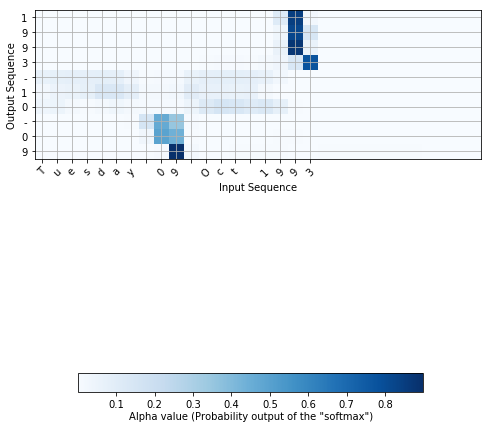

In [28]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64)

On the generated plot you can observe the values of the attention weights for each character of the predicted output. Examine this plot and check that where the network is paying attention makes sense to you.

In the date translation application, you will observe that most of the time attention helps predict the year, and hasn't much impact on predicting the day/month.

在生成的图上，您可以观察预测输出的每个字符的注意力权重值。 检查此图并检查网络注意力在哪里对您有意义。

在日期翻译应用程序中，您会发现大多数时间注意有助于预测年份，并且对预测日/月没有太大影响。

### Congratulations!


You have come to the end of this assignment 

<font color='blue'> **Here's what you should remember from this notebook**:

- Machine translation models can be used to map from one sequence to another. They are useful not just for translating human languages (like French->English) but also for tasks like date format translation. 
- An attention mechanism allows a network to focus on the most relevant parts of the input when producing a specific part of the output. 
- A network using an attention mechanism can translate from inputs of length $T_x$ to outputs of length $T_y$, where $T_x$ and $T_y$ can be different. 
- You can visualize attention weights $\alpha^{\langle t,t' \rangle}$ to see what the network is paying attention to while generating each output.

- 机器翻译模型可用于从一个序列映射到另一个序列。 它们不仅用于翻译人类语言（如法语 - >英语），还用于日期格式翻译等任务。

- 注意机制允许网络在产生输出的特定部分时专注于输入的最相关部分。

- 使用注意机制的网络可以从长度为 $T_x$ 的输入转换为长度为$T_y$的输出，其中 $T_x$ 和 $T_y$ 可以不同。

- 您可以将注意力权重$\alpha^{\langle t,t' \rangle}$可视化，以便在生成每个输出时查看网络正在关注的内容。


Congratulations on finishing this assignment! You are now able to implement an attention model and use it to learn complex mappings from one sequence to another. 